<a href="https://colab.research.google.com/github/zeinabmohamed/CIT690E-DeepLearning-Zeinab_Abdelmawla-191009/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1) Write a Python Colab Notebook: Use CIFAR-10 dataset and ResNet20, ResNet-32, ResNet-44 and ResNet-56 architectures in Pytorch to compute the
classification error and the number of parameters of each architecture as reported in
Table 6 of the following paper:
• He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image
recognition." In Proceedings of the IEEE CVPR 2016.
• Please note you should train your models on CIFAR-10 training set from scratch using the
instructions given in the above paper and in particular Section 4.2 and Figure 3.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyper-parameters
num_epochs = 80
batch_size = 128
learning_rate = 0.1
momentum = 0.9

Load the dataset CIFAR-10

In [ ]:
cifer10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifer10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataloader = torch.utils.data.DataLoader(cifer10_trainset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(cifer10_testset, batch_size=batch_size, shuffle=False)

print("Training dataset size: ", len(cifer10_trainset))
print("Testing dataset size: ", len(cifer10_testset))

Training dataset size:  50000
Testing dataset size:  10000


###Resnet

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [ ]:
def createResnetModelWithDepth(depth):
  noOfBlocks = int((depth-2/6))
  return ResNet(ResidualBlock, [noOfBlocks, noOfBlocks, noOfBlocks]).to(device)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def evaluate(model, data_loader, device):
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    
    with torch.no_grad():
      for data in data_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)

          y_true = np.concatenate((y_true, labels.cpu()))
          y_pred = np.concatenate((y_pred, predicted.cpu()))
    
    error = np.sum(y_pred != y_true) / len(y_true)
    return error


In [ ]:
# Train the model
import os

def trainModel(model,depth):
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,weight_decay=1e-4)

# Run on GPU if available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  model.to(device)

  outdir ='./results'
  if not os.path.exists(outdir):
    os.mkdir(outdir)

  cols = ['epoch', 'train_loss', 'train_err', 'test_err']
  results_df = pd.DataFrame(columns=cols).set_index('epoch')
  
  total_step = len(train_dataloader)
  curr_lr = learning_rate
  results_file = f'results/resnet{depth}.csv'

  for epoch in range(num_epochs):
    running_loss  = 0.0
    best_test_err = 1.0
    model.train()

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        #  optimize
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #Backward
        loss.backward()
        optimizer.step()
        
        # print average loss for last 50 mini-batches
        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)
    
    model.eval()

    train_loss = loss.item()
    train_err = evaluate(model, train_dataloader, device)
    test_err = evaluate(model, test_dataloader, device)
    results_df.loc[epoch] = [train_loss, train_err, test_err]
    results_df.to_csv(results_file)
    print(f'train_err: {train_err} test_err: {test_err}')

    model.eval()

  return train_loss

In [ ]:
# Test the model
def testModel(model):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [ ]:
#Calculate the total number of parameters for model stride 2
from prettytable import PrettyTable

def calculateModelParams(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
# Save the model checkpoint
def saveModel(model,layerNo):
  snapShotName = "resnet%s.ckpt" % (layerNo)
  torch.save(model.state_dict(), snapShotName)
  print(snapShotName)

**Resnet20**

In [ ]:
resnet20Model = createResnetModelWithDepth(20)
trainModel(resnet20Model,20)
testModel(resnet20Model)
saveModel(resnet20Model,20)


cuda:0
Epoch [1/80], Step [100/391] Loss: 2.2969
Epoch [1/80], Step [200/391] Loss: 2.2884
Epoch [1/80], Step [300/391] Loss: 1.9962
train_err: 0.72428 test_err: 0.7178
Epoch [2/80], Step [100/391] Loss: 1.8663
Epoch [2/80], Step [200/391] Loss: 1.8134
Epoch [2/80], Step [300/391] Loss: 1.7746
train_err: 0.61932 test_err: 0.6223
Epoch [3/80], Step [100/391] Loss: 1.6387
Epoch [3/80], Step [200/391] Loss: 1.5846
Epoch [3/80], Step [300/391] Loss: 1.3368
train_err: 0.48506 test_err: 0.4932
Epoch [4/80], Step [100/391] Loss: 1.1626
Epoch [4/80], Step [200/391] Loss: 1.2379
Epoch [4/80], Step [300/391] Loss: 1.2098
train_err: 0.38192 test_err: 0.3909
Epoch [5/80], Step [100/391] Loss: 0.9183
Epoch [5/80], Step [200/391] Loss: 0.8241
Epoch [5/80], Step [300/391] Loss: 0.8129
train_err: 0.37242 test_err: 0.388
Epoch [6/80], Step [100/391] Loss: 0.7824
Epoch [6/80], Step [200/391] Loss: 1.0576
Epoch [6/80], Step [300/391] Loss: 0.6191
train_err: 0.29032 test_err: 0.3105
Epoch [7/80], Step [10

**Resnet32**

In [ ]:
resnet32Model = createResnetModelWithDepth(32)
trainModel(resnet32Model,32)
testModel(resnet32Model)
saveModel(resnet32Model,32)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.2961
Epoch [1/80], Step [200/391] Loss: 2.2891
Epoch [1/80], Step [300/391] Loss: 2.3069
train_err: 0.88508 test_err: 0.885
Epoch [2/80], Step [100/391] Loss: 2.3254
Epoch [2/80], Step [200/391] Loss: 2.2633
Epoch [2/80], Step [300/391] Loss: 2.2886
train_err: 0.85666 test_err: 0.8587
Epoch [3/80], Step [100/391] Loss: 2.1978
Epoch [3/80], Step [200/391] Loss: 2.0728
Epoch [3/80], Step [300/391] Loss: 2.0154
train_err: 0.7054 test_err: 0.6979
Epoch [4/80], Step [100/391] Loss: 1.6755
Epoch [4/80], Step [200/391] Loss: 1.6022
Epoch [4/80], Step [300/391] Loss: 1.6328
train_err: 0.65028 test_err: 0.6583
Epoch [5/80], Step [100/391] Loss: 1.4646
Epoch [5/80], Step [200/391] Loss: 1.5313
Epoch [5/80], Step [300/391] Loss: 1.4068
train_err: 0.56016 test_err: 0.5619
Epoch [6/80], Step [100/391] Loss: 1.4321
Epoch [6/80], Step [200/391] Loss: 1.4216
Epoch [6/80], Step [300/391] Loss: 1.1875
train_err: 0.48928 test_err: 0.4972
Epoch [7/80], Step [100

**Resnet44**

In [ ]:
resnet44Model = createResnetModelWithDepth(44)
trainModel(resnet44Model,44)
testModel(resnet44Model)
saveModel(resnet44Model,44)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.2902
Epoch [1/80], Step [200/391] Loss: 2.2962
Epoch [1/80], Step [300/391] Loss: 2.3020
train_err: 0.8976 test_err: 0.897
Epoch [2/80], Step [100/391] Loss: 2.3211
Epoch [2/80], Step [200/391] Loss: 2.2911
Epoch [2/80], Step [300/391] Loss: 2.3040
train_err: 0.89818 test_err: 0.8997
Epoch [3/80], Step [100/391] Loss: 2.2993
Epoch [3/80], Step [200/391] Loss: 2.2811
Epoch [3/80], Step [300/391] Loss: 2.2781
train_err: 0.89962 test_err: 0.8995
Epoch [4/80], Step [100/391] Loss: 2.3024
Epoch [4/80], Step [200/391] Loss: 2.2986
Epoch [4/80], Step [300/391] Loss: 2.2140
train_err: 0.83594 test_err: 0.8347
Epoch [5/80], Step [100/391] Loss: 2.0337
Epoch [5/80], Step [200/391] Loss: 2.0738
Epoch [5/80], Step [300/391] Loss: 1.9323
train_err: 0.74904 test_err: 0.7484
Epoch [6/80], Step [100/391] Loss: 1.7836
Epoch [6/80], Step [200/391] Loss: 1.7977
Epoch [6/80], Step [300/391] Loss: 1.7815
train_err: 0.6747 test_err: 0.679
Epoch [7/80], Step [100/3

**Resnet56**

In [ ]:
resnet56Model = createResnetModelWithDepth(56)
trainModel(resnet56Model,56)
testModel(resnet56Model)
saveModel(resnet56Model,56)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.2851
Epoch [1/80], Step [200/391] Loss: 2.2793
Epoch [1/80], Step [300/391] Loss: 2.2381
train_err: 0.87336 test_err: 0.8722
Epoch [2/80], Step [100/391] Loss: 2.1901
Epoch [2/80], Step [200/391] Loss: 2.0979
Epoch [2/80], Step [300/391] Loss: 1.9811
train_err: 0.74428 test_err: 0.7405
Epoch [3/80], Step [100/391] Loss: 1.8649
Epoch [3/80], Step [200/391] Loss: 1.8804
Epoch [3/80], Step [300/391] Loss: 1.8222
train_err: 0.70926 test_err: 0.7092
Epoch [4/80], Step [100/391] Loss: 1.8655
Epoch [4/80], Step [200/391] Loss: 1.7609
Epoch [4/80], Step [300/391] Loss: 1.7350
train_err: 0.63418 test_err: 0.6375
Epoch [5/80], Step [100/391] Loss: 1.6834
Epoch [5/80], Step [200/391] Loss: 1.6493
Epoch [5/80], Step [300/391] Loss: 1.8242
train_err: 0.58242 test_err: 0.5856
Epoch [6/80], Step [100/391] Loss: 1.5505
Epoch [6/80], Step [200/391] Loss: 1.4106
Epoch [6/80], Step [300/391] Loss: 1.5584
train_err: 0.54658 test_err: 0.5525
Epoch [7/80], Step [1

###Classification error and the number of parameters of each architecture

In [ ]:
calculateModelParams(resnet20Model)
calculateModelParams(resnet32Model)
calculateModelParams(resnet44Model)
calculateModelParams(resnet56Model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv.weight          |    432     |
|          bn.weight           |     16     |
|           bn.bias            |     16     |
|    layer1.0.conv1.weight     |    2304    |
|     layer1.0.bn1.weight      |     16     |
|      layer1.0.bn1.bias       |     16     |
|    layer1.0.conv2.weight     |    2304    |
|     layer1.0.bn2.weight      |     16     |
|      layer1.0.bn2.bias       |     16     |
|    layer1.1.conv1.weight     |    2304    |
|     layer1.1.bn1.weight      |     16     |
|      layer1.1.bn1.bias       |     16     |
|    layer1.1.conv2.weight     |    2304    |
|     layer1.1.bn2.weight      |     16     |
|      layer1.1.bn2.bias       |     16     |
|    layer1.2.conv1.weight     |    2304    |
|     layer1.2.bn1.weight      |     16     |
|      layer1.2.bn1.bias       |     16     |
|    layer1.2.conv2.weight     |  

5348186

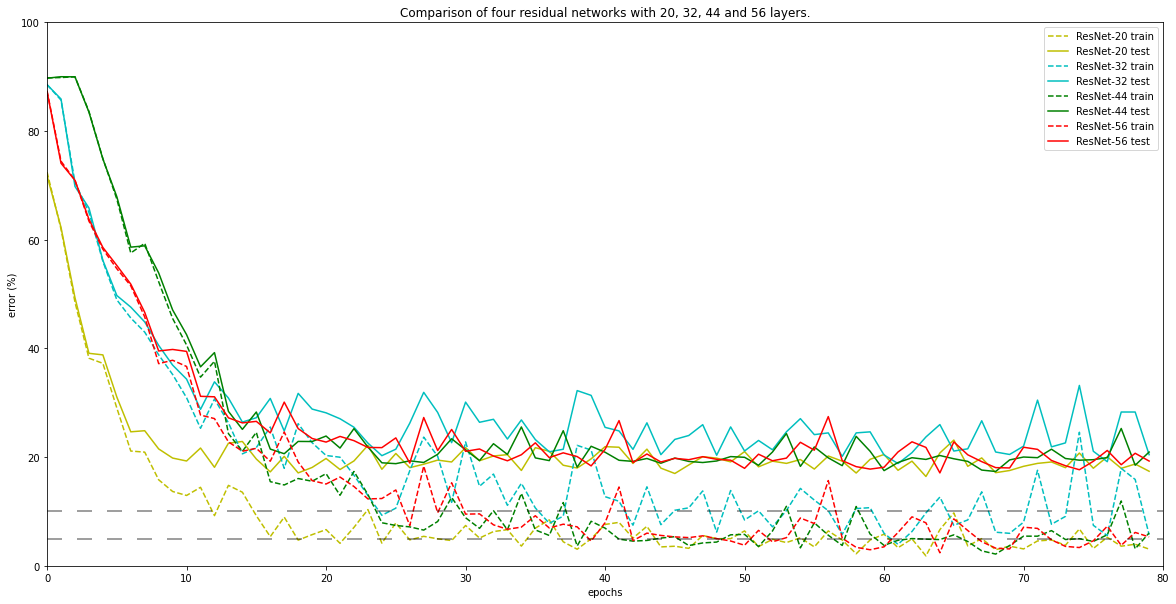

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 80, 0, 100])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
63,ResNet20,0.1643
61,ResNet32,0.1881
68,ResNet44,0.1735
64,ResNet56,0.1709


##Plain Network


In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# block(removing out += residual line to be plain network)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        ##out += residual
        out = self.relu(out)
        return out

# Plain network
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [ ]:
# Train the model
import os

def trainModel(model,depth):
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,weight_decay=1e-4)

# Run on GPU if available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  model.to(device)

  outdir ='./results'
  if not os.path.exists(outdir):
    os.mkdir(outdir)

  cols = ['epoch', 'train_loss', 'train_err', 'test_err']
  results_df = pd.DataFrame(columns=cols).set_index('epoch')
  
  total_step = len(train_dataloader)
  curr_lr = learning_rate
  results_file = f'results/plainnet{depth}.csv'

  for epoch in range(num_epochs):
    running_loss  = 0.0
    best_test_err = 1.0
    model.train()

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        #  optimize
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #Backward
        loss.backward()
        optimizer.step()
        
        # print average loss for last 50 mini-batches
        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)
    
    model.eval()

    train_loss = loss.item()
    train_err = evaluate(model, train_dataloader, device)
    test_err = evaluate(model, test_dataloader, device)
    results_df.loc[epoch] = [train_loss, train_err, test_err]
    results_df.to_csv(results_file)
    print(f'train_err: {train_err} test_err: {test_err}')

    model.eval()

  return train_loss

In [ ]:
# Save the model checkpoint
def saveModel(model,layerNo):
  snapShotName = "plainnet%s.ckpt" % (layerNo)
  torch.save(model.state_dict(), snapShotName)
  print(snapShotName)

In [ ]:
Plainnetwork20Model = createResnetModelWithDepth(20)
trainModel(Plainnetwork20Model,20)
testModel(Plainnetwork20Model)
saveModel(Plainnetwork20Model,20)


cuda:0
Epoch [1/80], Step [100/391] Loss: 2.3083
Epoch [1/80], Step [200/391] Loss: 2.3101
Epoch [1/80], Step [300/391] Loss: 2.3002
train_err: 0.90062 test_err: 0.8999
Epoch [2/80], Step [100/391] Loss: 2.2995
Epoch [2/80], Step [200/391] Loss: 2.2988
Epoch [2/80], Step [300/391] Loss: 2.3031
train_err: 0.89874 test_err: 0.8987
Epoch [3/80], Step [100/391] Loss: 2.2975
Epoch [3/80], Step [200/391] Loss: 2.3144
Epoch [3/80], Step [300/391] Loss: 2.3144
train_err: 0.89978 test_err: 0.8997
Epoch [4/80], Step [100/391] Loss: 2.3030
Epoch [4/80], Step [200/391] Loss: 2.2955
Epoch [4/80], Step [300/391] Loss: 2.3238
train_err: 0.89994 test_err: 0.8999
Epoch [5/80], Step [100/391] Loss: 2.3022
Epoch [5/80], Step [200/391] Loss: 2.3034
Epoch [5/80], Step [300/391] Loss: 2.3003
train_err: 0.90004 test_err: 0.8998
Epoch [6/80], Step [100/391] Loss: 2.3075
Epoch [6/80], Step [200/391] Loss: 2.2985
Epoch [6/80], Step [300/391] Loss: 2.2939
train_err: 0.89978 test_err: 0.9001
Epoch [7/80], Step [1

In [ ]:
Plainnetwork32Model = createResnetModelWithDepth(32)
trainModel(Plainnetwork32Model,32)
testModel(Plainnetwork32Model)
saveModel(Plainnetwork32Model,32)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.2968
Epoch [1/80], Step [200/391] Loss: 2.2972
Epoch [1/80], Step [300/391] Loss: 2.3126
train_err: 0.9 test_err: 0.9
Epoch [2/80], Step [100/391] Loss: 2.3053
Epoch [2/80], Step [200/391] Loss: 2.3082
Epoch [2/80], Step [300/391] Loss: 2.3030
train_err: 0.9 test_err: 0.9
Epoch [3/80], Step [100/391] Loss: 2.3096
Epoch [3/80], Step [200/391] Loss: 2.3049
Epoch [3/80], Step [300/391] Loss: 2.3085
train_err: 0.9 test_err: 0.9
Epoch [4/80], Step [100/391] Loss: 2.2987
Epoch [4/80], Step [200/391] Loss: 2.3000
Epoch [4/80], Step [300/391] Loss: 2.2993
train_err: 0.9 test_err: 0.9
Epoch [5/80], Step [100/391] Loss: 2.3017
Epoch [5/80], Step [200/391] Loss: 2.3028
Epoch [5/80], Step [300/391] Loss: 2.3146
train_err: 0.9 test_err: 0.9
Epoch [6/80], Step [100/391] Loss: 2.3054
Epoch [6/80], Step [200/391] Loss: 2.3073
Epoch [6/80], Step [300/391] Loss: 2.3056
train_err: 0.9 test_err: 0.9
Epoch [7/80], Step [100/391] Loss: 2.2884
Epoch [7/80], Step [2

In [ ]:
Plainnetwork44Model = createResnetModelWithDepth(44)
trainModel(Plainnetwork44Model,44)
testModel(Plainnetwork44Model)
saveModel(Plainnetwork44Model,44)

cuda:0
Epoch [1/80], Step [100/391] Loss: nan
Epoch [1/80], Step [200/391] Loss: nan
Epoch [1/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [2/80], Step [100/391] Loss: nan
Epoch [2/80], Step [200/391] Loss: nan
Epoch [2/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [3/80], Step [100/391] Loss: nan
Epoch [3/80], Step [200/391] Loss: nan
Epoch [3/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [4/80], Step [100/391] Loss: nan
Epoch [4/80], Step [200/391] Loss: nan
Epoch [4/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [5/80], Step [100/391] Loss: nan
Epoch [5/80], Step [200/391] Loss: nan
Epoch [5/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [6/80], Step [100/391] Loss: nan
Epoch [6/80], Step [200/391] Loss: nan
Epoch [6/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [7/80], Step [100/391] Loss: nan
Epoch [7/80], Step [200/391] Loss: nan
Epoch [7/80], Step [300/391] Loss: nan


In [ ]:
Plainnetwork56Model = createResnetModelWithDepth(56)
trainModel(Plainnetwork56Model,56)
testModel(Plainnetwork56Model)
saveModel(Plainnetwork56Model,56)

cuda:0
Epoch [1/80], Step [100/391] Loss: nan
Epoch [1/80], Step [200/391] Loss: nan
Epoch [1/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [2/80], Step [100/391] Loss: nan
Epoch [2/80], Step [200/391] Loss: nan
Epoch [2/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [3/80], Step [100/391] Loss: nan
Epoch [3/80], Step [200/391] Loss: nan
Epoch [3/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [4/80], Step [100/391] Loss: nan
Epoch [4/80], Step [200/391] Loss: nan
Epoch [4/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [5/80], Step [100/391] Loss: nan
Epoch [5/80], Step [200/391] Loss: nan
Epoch [5/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [6/80], Step [100/391] Loss: nan
Epoch [6/80], Step [200/391] Loss: nan
Epoch [6/80], Step [300/391] Loss: nan
train_err: 0.9 test_err: 0.9
Epoch [7/80], Step [100/391] Loss: nan
Epoch [7/80], Step [200/391] Loss: nan
Epoch [7/80], Step [300/391] Loss: nan


###Classification error and the number of parameters of each architecture

In [ ]:
calculateModelParams(Plainnetwork20Model)
calculateModelParams(Plainnetwork32Model)
calculateModelParams(Plainnetwork44Model)
calculateModelParams(Plainnetwork56Model)

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


plainnet_dfs = [pd.read_csv(f'results/Plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 80, 0, 100])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

 ##Q2) In the same Notebook, plot the classification error vs. the number of epochs for the above 4 ResNet architectures and in addition those generated by using deep CNN models without residual links (plain network presented at Figure 3middle of the above paper) of depth 20, 32, 44 and 56 layers, and

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 80, 0, 100])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')